# Import Packages

In [1]:
# data preprocessing modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, classification_report

# deep learning modules
import tensorflow as tf
import keras
from keras.layers import Conv2D, MaxPool2D, Dense, Input, Flatten
from keras.models import Sequential, Model
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.utils import plot_model

# data loading modules
from keras.utils import image_dataset_from_directory, load_img, img_to_array

# Image related modules
from PIL import Image

from pathlib import Path

2024-05-28 16:32:12.756422: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-28 16:32:12.756538: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-28 16:32:12.925945: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Preprocessing

In [2]:
# paths of the training and test datasets

train_path = Path("/kaggle/input/emotion-detection-fer/train")

test_path = Path("/kaggle/input/emotion-detection-fer/test")

In [3]:
import os

## Class Names

In [4]:
# get all the class names

class_names = []

for files in train_path.iterdir():
    class_names.append(files.stem)

class_names

['fearful', 'disgusted', 'angry', 'neutral', 'sad', 'surprised', 'happy']

## Prepare Directories into train and test

In [5]:
# all the filenames from all the directories
train_filenames = {}

for files in train_path.iterdir():
    train_filenames[files.stem] = {'filenames': [filename for filename in files.iterdir()],
                                   'count': len([filename for filename in files.iterdir()])}

In [6]:
test_filenames = {}

for files in test_path.iterdir():
    test_filenames[files.stem] = {'filenames': [filename for filename in files.iterdir()],
                                   'count': len([filename for filename in files.iterdir()])}

## Make the class distribution

In [7]:
# file count

class_dist = {key:train_filenames[key]['count'] for key in train_filenames}

class_dist

{'fearful': 4097,
 'disgusted': 436,
 'angry': 3995,
 'neutral': 4965,
 'sad': 4830,
 'surprised': 3171,
 'happy': 7215}

<Axes: >

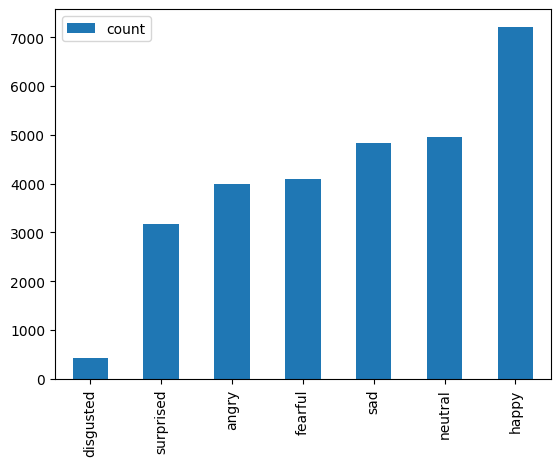

In [8]:
# make a bar chart of class dist

pd.DataFrame(class_dist,index=['count']).T.sort_values(by='count').plot(kind='bar')

In [9]:
len(class_names)

7

In [10]:
from math import ceil
from random import choice

# Plot Sample Images

In [11]:
def plot_image_each_category():
    num_of_classes = len(class_names)
    num_of_rows = ceil(num_of_classes / 4)
    num_of_cols = 4
    fig = plt.figure(figsize=(10,10))
    for ind in range(num_of_classes):
        # read a random file from directory
        random_filename = choice(train_filenames[class_names[ind]]['filenames'])
        plt.subplot(num_of_rows,num_of_cols,ind+1)
        img = Image.open(random_filename)
        plt.imshow(img,cmap='gray')
        plt.title(f'Emotion = {class_names[ind]}')
        plt.axis('off')

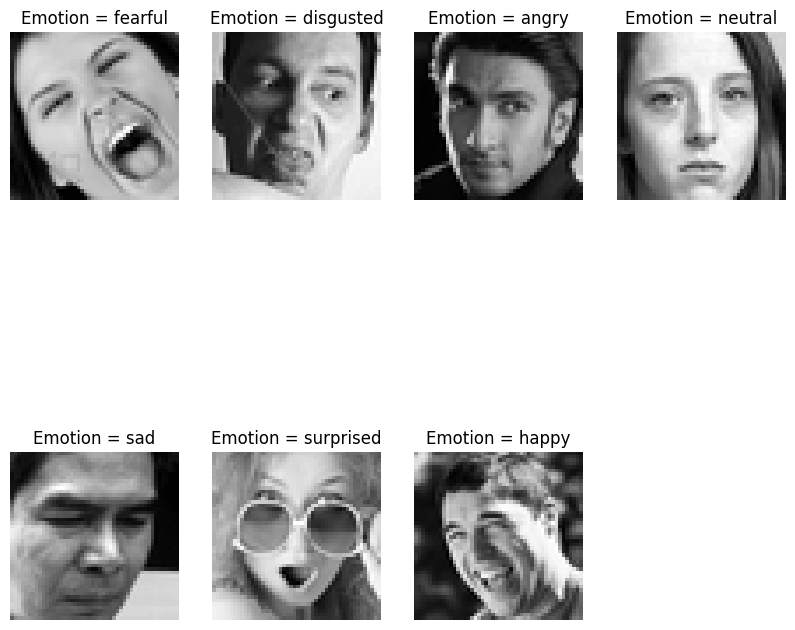

In [12]:
plot_image_each_category()

# Data Validation

In [13]:
from collections import Counter

## Validate File Extensions

In [14]:
# validate the extensions of all images

def check_image_extensions(filenames):
    for class_name in class_names:
        counts = Counter(f.suffix for f in filenames[class_name]['filenames'])
        print(f'For emotion {class_name.upper()} the file extensions are {counts}')

In [15]:
train_filenames['disgusted']['filenames'][0].suffix

'.png'

In [16]:
# check file extensions for training data

check_image_extensions(train_filenames)

For emotion FEARFUL the file extensions are Counter({'.png': 4097})
For emotion DISGUSTED the file extensions are Counter({'.png': 436})
For emotion ANGRY the file extensions are Counter({'.png': 3995})
For emotion NEUTRAL the file extensions are Counter({'.png': 4965})
For emotion SAD the file extensions are Counter({'.png': 4830})
For emotion SURPRISED the file extensions are Counter({'.png': 3171})
For emotion HAPPY the file extensions are Counter({'.png': 7215})


In [17]:
# check file extensions for test data

check_image_extensions(test_filenames)

For emotion FEARFUL the file extensions are Counter({'.png': 1024})
For emotion DISGUSTED the file extensions are Counter({'.png': 111})
For emotion ANGRY the file extensions are Counter({'.png': 958})
For emotion NEUTRAL the file extensions are Counter({'.png': 1233})
For emotion SAD the file extensions are Counter({'.png': 1247})
For emotion SURPRISED the file extensions are Counter({'.png': 831})
For emotion HAPPY the file extensions are Counter({'.png': 1774})


## Validate File loading

In [18]:
# validate file reads

def validate_files(filenames):
    for class_name in class_names:
        paths = filenames[class_name]['filenames']
        for path in paths:
            try:
                img = Image.open(path)
            except Exception as e:
                print(f'Could not open the file {path}')
                os.remove(path)

In [19]:
# validate the training files

#validate_files(train_filenames)

In [20]:
# validate the test files

#validate_files(test_filenames)

# Handle Class Imbalance

In [21]:
class_dist_df = pd.DataFrame(class_dist,index=['count']).T

class_dist_df['weights'] = (class_dist_df['count'].sum() / class_dist_df['count']) / 10

class_dist_df

,count,weights
fearful,4097,0.700732
disgusted,436,6.584633
angry,3995,0.718623
neutral,4965,0.578228
sad,4830,0.594389
surprised,3171,0.905361
happy,7215,0.397907


In [22]:
# adjust the class weights to solve imbalance dataset problem
class_weights = class_dist_df['weights'].values

class_weights

array([0.70073224, 6.58463303, 0.71862328, 0.57822759, 0.59438923,
       0.90536108, 0.39790714])

In [23]:
# read an image to check size

plt.imread(train_filenames['sad']['filenames'][10]).shape

(48, 48)

# Load the train and test data into Data Generator

In [24]:
BATCH_SIZE = 32
IMG_WIDTH = 48
IMG_HEIGHT = 48

In [25]:
# create the train and test datasets

train_dataset = image_dataset_from_directory(directory=train_path,
                                             class_names=class_names,
                                             color_mode='grayscale',
                                             batch_size=BATCH_SIZE,
                                             image_size=(48,48),
                                             seed=42)

test_dataset = image_dataset_from_directory(directory=test_path,
                                             class_names=class_names,
                                             color_mode='grayscale',
                                             batch_size=BATCH_SIZE,
                                             image_size=(48,48),
                                             seed=42)

Found 28709 files belonging to 7 classes.
Found 7178 files belonging to 7 classes.


# Model

## Build the model architecture

In [26]:
from keras.layers import Rescaling

In [27]:
from keras.layers import BatchNormalization
from keras.layers import Dropout

In [28]:
# build the neural network

model = Sequential()

# input layer
model.add(Input(shape=(48,48,1)))


# rescale the images
model.add(Rescaling(scale=1./255))

# first convolution layer with pooling
model.add(Conv2D(filters=512,kernel_size=(3,3),padding='same',activation='relu'))
model.add(Conv2D(filters=512,kernel_size=(3,3),padding='same',activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2,2)))

# second convolution layer with pooling
model.add(Conv2D(filters=256,kernel_size=(3,3),padding='same',activation='relu'))
model.add(Conv2D(filters=256,kernel_size=(3,3),padding='same',activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2,2)))

# third convolution layer with pooling
model.add(Conv2D(filters=256,kernel_size=(3,3),padding='same',activation='relu'))
model.add(Conv2D(filters=256,kernel_size=(3,3),padding='same',activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2,2)))

# fourth convolution layer with pooling
model.add(Conv2D(filters=128,kernel_size=(3,3),padding='same',activation='relu'))
model.add(Conv2D(filters=128,kernel_size=(3,3),padding='same',activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2,2)))

# add flatten layer
model.add(Flatten())

# create fully connected layers
model.add(Dense(units=512,activation='relu'))
model.add(Dense(units=256,activation='relu'))
model.add(Dense(units=256,activation='relu'))
model.add(Dropout(rate=0.2))

# create the output layer
model.add(Dense(units=7,activation='softmax'))

### Generate model summary

In [29]:
# generate model summary

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 48, 48, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 48, 48, 512)    │         5,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 48, 48, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 48, 48, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 24, 24, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 24, 24, 256)    │     1,179,904 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 24, 24, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 24, 24, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 12, 12, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 12, 12, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 12, 12, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 6, 6, 128)      │       295,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 6, 6, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 6, 6, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 3, 3, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1152)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       590,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 7)              │         1,79

 Total params: 6,551,559 (24.99 MB)

 Trainable params: 6,549,255 (24.98 MB)

 Non-trainable params: 2,304 (9.00 KB)

### Plot Model Architecture

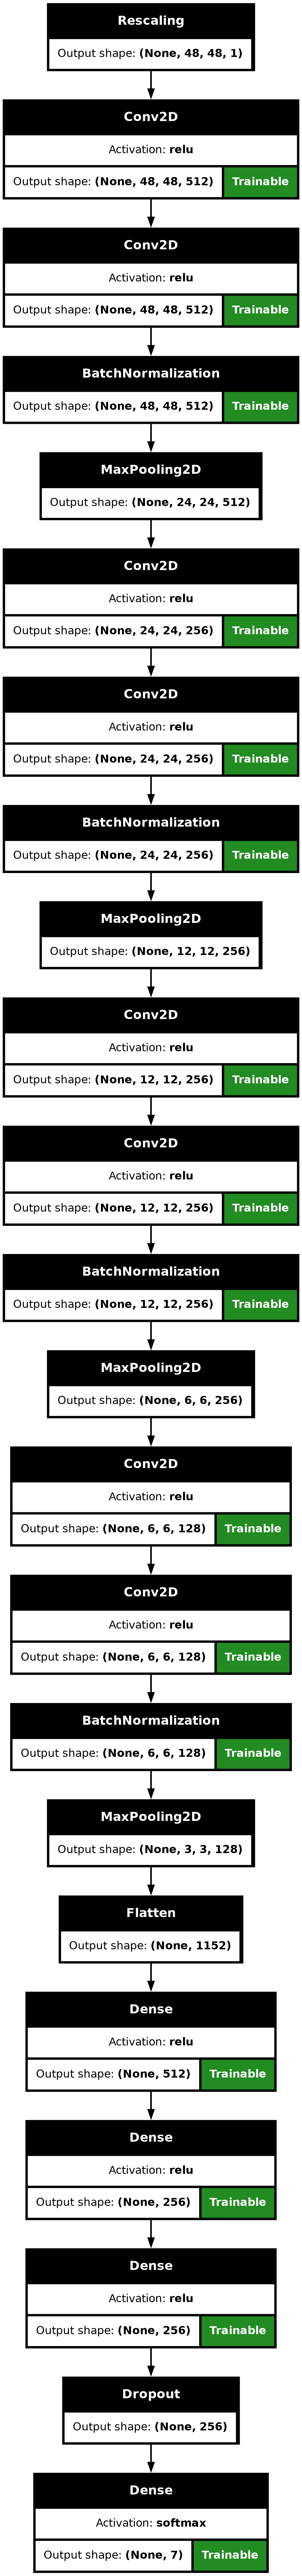

In [30]:
# plot the model

plot_model(model,show_shapes=True,show_layer_activations=True,show_trainable=True)

## Model Compilation

In [31]:
pwd

'/kaggle/working'

In [32]:
from pathlib import Path
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [33]:
# model checkpoint callback

save_filepath ="/kaggle/working/model-checkpoint/"
Path(save_filepath).mkdir(parents=True, exist_ok=True)

my_callbacks = [
    ModelCheckpoint(
        filepath="/kaggle/working/model-checkpoint/{epoch:02d}-{val_loss:.2f}.keras" ,
        monitor="val_loss",
        verbose=1,
        save_best_only=True,
        save_weights_only=False,
        mode="min",
        save_freq="epoch",
        initial_value_threshold=None,
    ),
    EarlyStopping(monitor="val_loss",
                  min_delta=0.1,
                  patience=5,
                  verbose=1,
                  mode='min',
                  restore_best_weights=True),
#     ReduceLROnPlateau(factor=0.1,
#                      patience=2,
#                      verbose=1,
#                      min_delta=0.1)
]

[x.__class__.__name__ for x in my_callbacks]

['ModelCheckpoint', 'EarlyStopping']

In [34]:
from keras.optimizers import Adam

In [35]:
# compile the model

model.compile(optimizer=Adam(learning_rate=0.0003),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [36]:
class_dist_df

,count,weights
fearful,4097,0.700732
disgusted,436,6.584633
angry,3995,0.718623
neutral,4965,0.578228
sad,4830,0.594389
surprised,3171,0.905361
happy,7215,0.397907


In [37]:
class_weights_model = {k:v for k,v in zip(range(7),class_weights)}

class_weights_model

{0: 0.7007322431047107,
 1: 6.584633027522936,
 2: 0.7186232790988736,
 3: 0.5782275931520645,
 4: 0.5943892339544513,
 5: 0.9053610848312836,
 6: 0.3979071379071379}

## Model Training

In [38]:
from warnings import filterwarnings

filterwarnings('ignore')


In [39]:
# # fit on the training data

# history = model.fit(train_dataset, epochs=3,
#                     validation_data=test_dataset,
#                     class_weight=class_weights_model,
#                     callbacks=my_callbacks)

In [40]:
# history = history.history

In [41]:
# # plot the accuracy curves

# plt.plot(history['accuracy'],label='train_accuracy')
# plt.plot(history['val_accuracy'],label='validation_accuracy')
# plt.legend()
# plt.show()

In [42]:
# from keras.saving import save_model


# save_model_path = Path("/kaggle/working/model/")

# save_model_path.mkdir(exist_ok=True)

# save_model(model=model,
#           filepath=save_model_path / "model_ver_3.keras")

## ResNet 50 V2

In [43]:
from keras.applications import ResNet50V2

In [44]:
# create the train and test datasets

train_dataset = image_dataset_from_directory(directory=train_path,
                                             class_names=class_names,
                                             color_mode='rgb',
                                             batch_size=BATCH_SIZE,
                                             image_size=(48,48),
                                             seed=42)

test_dataset = image_dataset_from_directory(directory=test_path,
                                             class_names=class_names,
                                             color_mode='rgb',
                                             batch_size=BATCH_SIZE,
                                             image_size=(48,48),
                                             seed=42)

Found 28709 files belonging to 7 classes.
Found 7178 files belonging to 7 classes.


In [45]:
resnet = ResNet50V2(include_top=False,
                    input_shape=(48,48,3))

94668760/94668760 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [46]:
resnet.summary()

Model: "resnet50v2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 48, 48, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 54, 54, 3) │          0 │ input_layer_1[0]… │
│ (ZeroPadding2D)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 24, 24,    │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 26, 26,    │          0 │ conv1_conv[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 12, 12,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_preac… │ (None, 12, 12,    │        256 │ pool1_pool[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_preac… │ (None, 12, 12,    │          0 │ conv2_block1_pre… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 12, 12,    │      4,096 │ conv2_block1_pre… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 12, 12,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 12, 12,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_pad  │ (None, 14, 14,    │          0 │ conv2_block1_1_r… │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 12, 12,    │     36,864 │ conv2_block1_2_p… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 12, 12,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 12, 12,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 12, 12,    │     16,640 │ conv2_block1_pre… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 12, 12,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_out    │ (None, 12, 12,    │          0 │ conv2_block1_0_c

 Total params: 23,564,800 (89.89 MB)

 Trainable params: 23,519,360 (89.72 MB)

 Non-trainable params: 45,440 (177.50 KB)

In [47]:
resnet.layers[:-34]

[<InputLayer name=input_layer_1, built=True>,
 <ZeroPadding2D name=conv1_pad, built=True>,
 <Conv2D name=conv1_conv, built=True>,
 <ZeroPadding2D name=pool1_pad, built=True>,
 <MaxPooling2D name=pool1_pool, built=True>,
 <BatchNormalization name=conv2_block1_preact_bn, built=True>,
 <Activation name=conv2_block1_preact_relu, built=True>,
 <Conv2D name=conv2_block1_1_conv, built=True>,
 <BatchNormalization name=conv2_block1_1_bn, built=True>,
 <Activation name=conv2_block1_1_relu, built=True>,
 <ZeroPadding2D name=conv2_block1_2_pad, built=True>,
 <Conv2D name=conv2_block1_2_conv, built=True>,
 <BatchNormalization name=conv2_block1_2_bn, built=True>,
 <Activation name=conv2_block1_2_relu, built=True>,
 <Conv2D name=conv2_block1_0_conv, built=True>,
 <Conv2D name=conv2_block1_3_conv, built=True>,
 <Add name=conv2_block1_out, built=True>,
 <BatchNormalization name=conv2_block2_preact_bn, built=True>,
 <Activation name=conv2_block2_preact_relu, built=True>,
 <Conv2D name=conv2_block2_1_con

In [48]:
resnet.layers[7]

<Conv2D name=conv2_block1_1_conv, built=True>

In [49]:
[ind for ind,val in enumerate(resnet.layers) if val.name.find('_conv') is not -1]

[2,
 7,
 11,
 14,
 15,
 19,
 23,
 26,
 30,
 34,
 38,
 42,
 46,
 49,
 50,
 54,
 58,
 61,
 65,
 69,
 72,
 76,
 80,
 84,
 88,
 92,
 95,
 96,
 100,
 104,
 107,
 111,
 115,
 118,
 122,
 126,
 129,
 133,
 137,
 140,
 144,
 148,
 152,
 156,
 160,
 163,
 164,
 168,
 172,
 175,
 179,
 183,
 186]

In [50]:
# make all the layers in resnet non trainable

resnet.trainable = True

for layer in resnet.layers[:7]:
    layer.trainable = False

In [51]:
resnet.inputs

[<KerasTensor shape=(None, 48, 48, 3), dtype=float32, sparse=None, name=keras_tensor_277>]

In [52]:
resnet.output

<KerasTensor shape=(None, 2, 2, 2048), dtype=float32, sparse=False, name=keras_tensor_466>

In [53]:
# add fully connected layer

dense_1 = Dense(units=1024,activation='relu',kernel_regularizer='l2',bias_regularizer='l2')
dense_2 = Dense(units=512,activation='relu',kernel_regularizer='l2',bias_regularizer='l2')
dense_3 = Dense(units=256,activation='relu',kernel_regularizer='l2',bias_regularizer='l2')

In [54]:
# input layer
input_layer = Input(shape=(48,48,3))


# rescale the images
rescale_layer = Rescaling(scale=1./255)(input_layer)

# resnet model
resnet_model = resnet(rescale_layer)
resnet_dropout = Dropout(rate=0.5)(resnet_model)

# dense layers
flatten_layer = Flatten()(resnet_dropout)

# fc layer 1 after flatten
fc_layer_1 = dense_1(flatten_layer)
batch_norm_1 = BatchNormalization()(fc_layer_1)
drop_out_1 = Dropout(rate=0.2)(batch_norm_1)

# fc layer 2 
fc_layer_2 = dense_2(drop_out_1)
batch_norm_2 = BatchNormalization()(fc_layer_2)
drop_out_2 = Dropout(rate=0.2)(batch_norm_2)

# fc layer 3
fc_layer_3 = dense_3(drop_out_2)
batch_norm_3 = BatchNormalization()(fc_layer_3)
drop_out_3 = Dropout(rate=0.2)(batch_norm_3)

# output layer

output_layer = Dense(units=7,activation='softmax',kernel_regularizer='l2',bias_regularizer='l2')(drop_out_3)

In [55]:
final_model = Model(inputs=input_layer,outputs=output_layer)

final_model.summary()

Model: "functional_24"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 48, 48, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_1 (Rescaling)         │ (None, 48, 48, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50v2 (Functional)         │ (None, 2, 2, 2048)     │    23,564,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 2, 2, 2048)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1024)           │     8,389,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 1024)           │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 7)              │         1,799 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 32,619,527 (124.43 MB)

 Trainable params: 32,560,903 (124.21 MB)

 Non-trainable params: 58,624 (229.00 KB)

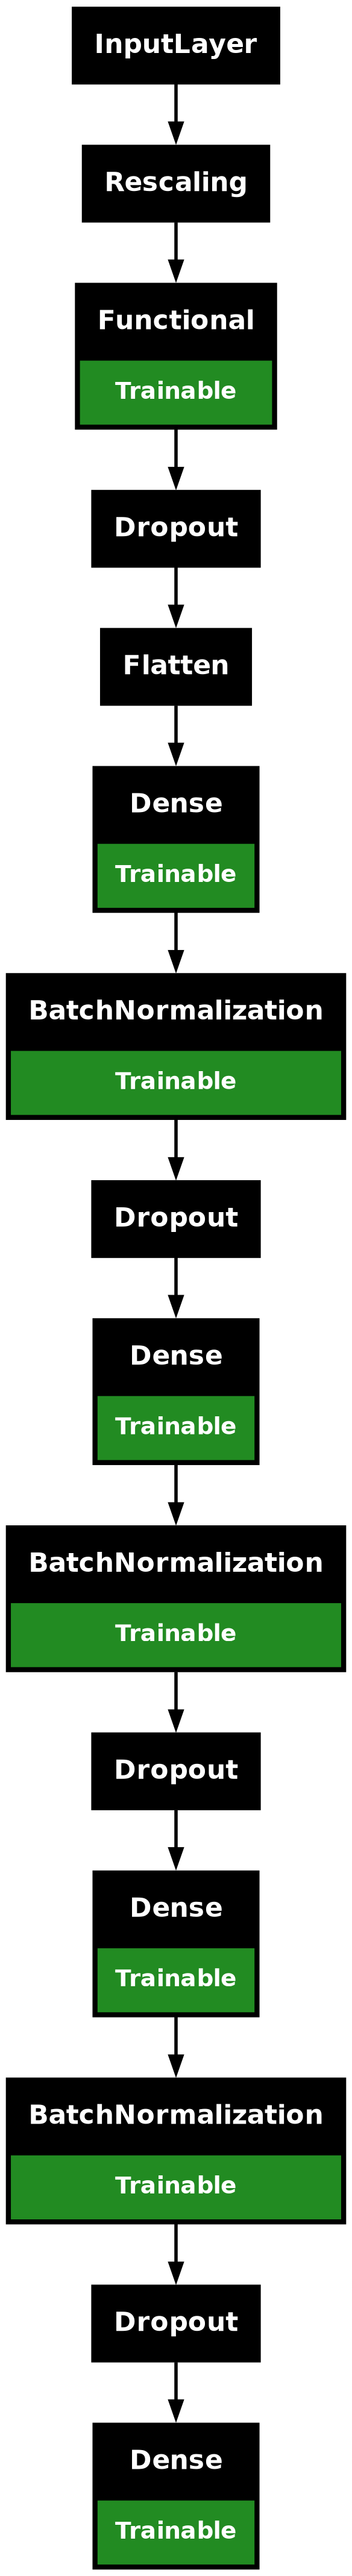

In [56]:
# plot model

plot_model(final_model,show_trainable=True)

In [57]:
class_dist

{'fearful': 4097,
 'disgusted': 436,
 'angry': 3995,
 'neutral': 4965,
 'sad': 4830,
 'surprised': 3171,
 'happy': 7215}

In [58]:
class_weights_model

{0: 0.7007322431047107,
 1: 6.584633027522936,
 2: 0.7186232790988736,
 3: 0.5782275931520645,
 4: 0.5943892339544513,
 5: 0.9053610848312836,
 6: 0.3979071379071379}

In [59]:
sum(list(class_dist.values()))

28709

In [60]:
# compute the class weights

number_of_classes = 7

number_of_samples = sum(list(class_dist.values()))

bin_count = [bins for bins in class_dist.values()]

class_weights = {class_name : (number_of_samples/(number_of_classes * bins)) for class_name,bins in zip(range(0,7),bin_count)}

class_weights

{0: 1.0010460615781582,
 1: 9.406618610747051,
 2: 1.0266046844269623,
 3: 0.8260394187886635,
 4: 0.8491274770777877,
 5: 1.293372978330405,
 6: 0.5684387684387684}

In [61]:
# model checkpoint callback

save_filepath ="/kaggle/working/resnet/"
Path(save_filepath).mkdir(parents=True, exist_ok=True)

my_callbacks = [
    ModelCheckpoint(
        filepath="/kaggle/working/resnet/model.keras" ,
        monitor="loss",
        verbose=1,
        save_best_only=True,
        save_weights_only=False,
        mode="min",
        save_freq="epoch",
        initial_value_threshold=None,
    ),
#     EarlyStopping(monitor="val_loss",
#                   min_delta=0.1,
#                   patience=30,
#                   verbose=1,
#                   mode='min',
#                   restore_best_weights=True),
#     ReduceLROnPlateau(factor=0.1,
#                      patience=2,
#                      verbose=1,
#                      min_delta=0.3)
]

[x.__class__.__name__ for x in my_callbacks]

['ModelCheckpoint']

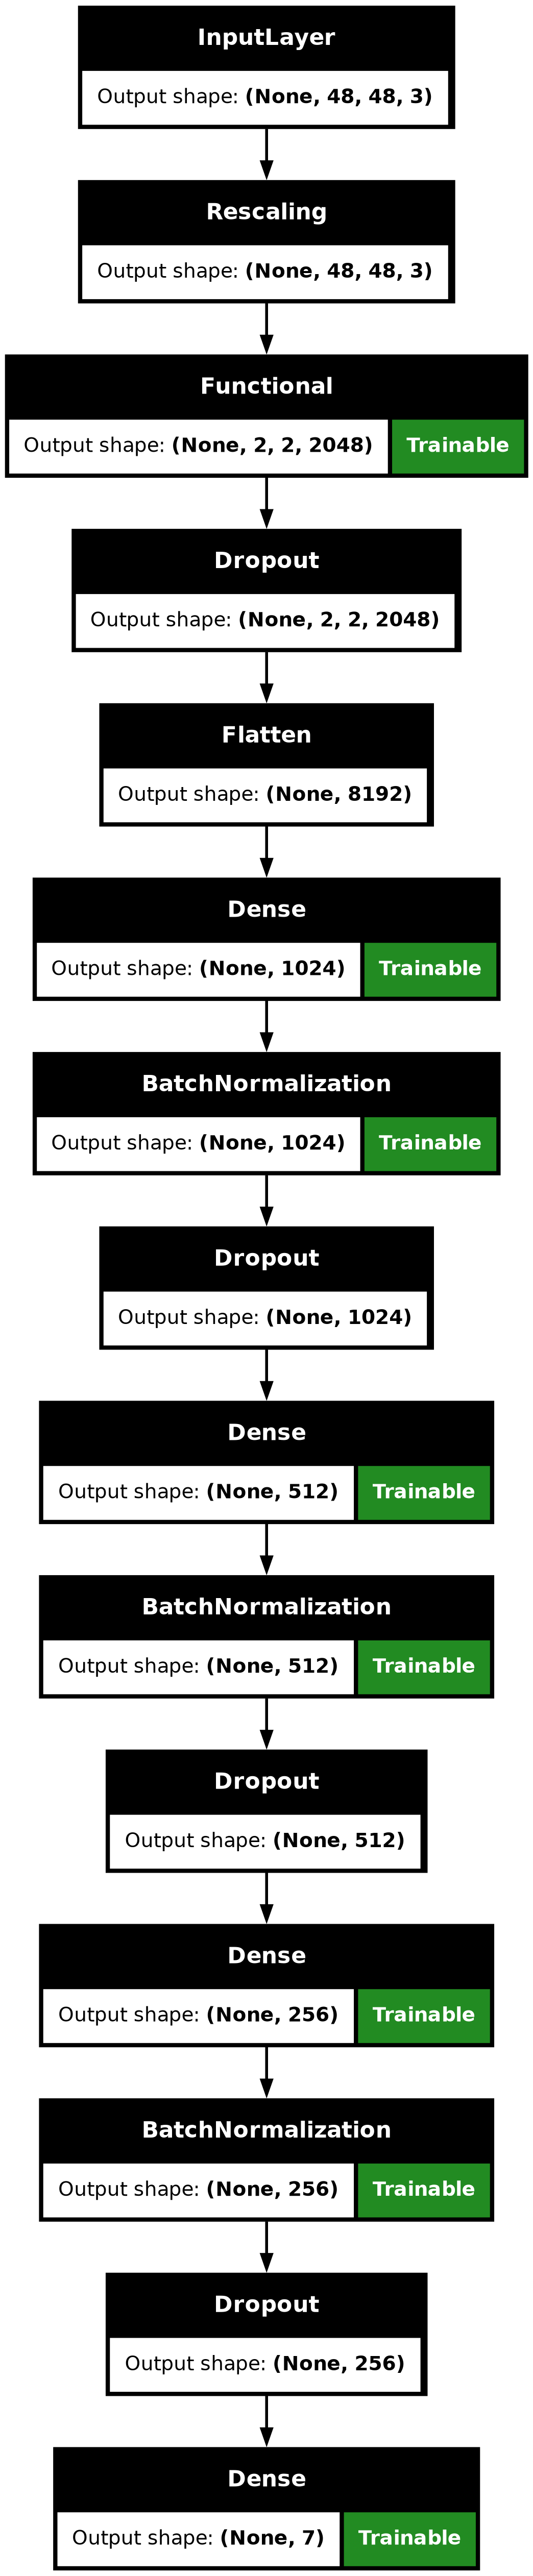

In [62]:
# plot the model

plot_model(model=final_model,
          show_shapes=True,
          show_trainable=True)

In [63]:
class_weights

{0: 1.0010460615781582,
 1: 9.406618610747051,
 2: 1.0266046844269623,
 3: 0.8260394187886635,
 4: 0.8491274770777877,
 5: 1.293372978330405,
 6: 0.5684387684387684}

In [64]:
# compile the model
final_model.compile(optimizer=Adam(learning_rate=0.005), loss='sparse_categorical_crossentropy',
                   metrics=['accuracy'])

In [65]:
# fit the resnet model with epochs = 100

history = final_model.fit(train_dataset, epochs=100,
                          validation_data=test_dataset,
                          class_weight=class_weights,
                          callbacks=my_callbacks)

Epoch 1/100
  1/898 ━━━━━━━━━━━━━━━━━━━━ 16:36:00 67s/step - accuracy: 0.0938 - loss: 31.1050

I0000 00:00:1716914041.765648     115 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1716914041.854681     115 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


898/898 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.1299 - loss: 12.8634

W0000 00:00:1716914114.682496     112 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1716914119.006040     112 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update



Epoch 1: loss improved from inf to 8.01771, saving model to /kaggle/working/resnet/model.keras


W0000 00:00:1716914131.040612     113 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


898/898 ━━━━━━━━━━━━━━━━━━━━ 158s 101ms/step - accuracy: 0.1299 - loss: 12.8580 - val_accuracy: 0.1441 - val_loss: 5.4699
Epoch 2/100
898/898 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.1220 - loss: 4.7216
Epoch 2: loss improved from 8.01771 to 3.92798, saving model to /kaggle/working/resnet/model.keras
898/898 ━━━━━━━━━━━━━━━━━━━━ 44s 49ms/step - accuracy: 0.1220 - loss: 4.7207 - val_accuracy: 0.1864 - val_loss: 2.6348
Epoch 3/100
898/898 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.1509 - loss: 3.0064
Epoch 3: loss improved from 3.92798 to 2.83371, saving model to /kaggle/working/resnet/model.keras
898/898 ━━━━━━━━━━━━━━━━━━━━ 43s 48ms/step - accuracy: 0.1509 - loss: 3.0062 - val_accuracy: 0.2632 - val_loss: 2.6432
Epoch 4/100
897/898 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.1808 - loss: 2.4708
Epoch 4: loss improved from 2.83371 to 2.48909, saving model to /kaggle/working/resnet/model.keras
898/898 ━━━━━━━━━━━━━━━━━━━━ 43s 48ms/step - accuracy: 0.1808 - loss: 2.4708 - 

In [66]:
# evaluate the model

final_model.evaluate(train_dataset)

898/898 ━━━━━━━━━━━━━━━━━━━━ 12s 13ms/step - accuracy: 0.9059 - loss: 1.0354


W0000 00:00:1716918398.716459     114 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


[1.0199998617172241, 0.9120484590530396]

In [67]:
final_model.evaluate(test_dataset)

225/225 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.5425 - loss: 2.4243


[2.4552161693573, 0.537754237651825]

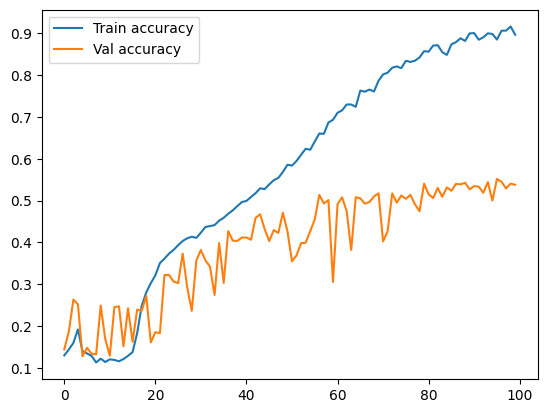

In [68]:
# do the plotting of accuracy

plt.plot(history.history['accuracy'],label='Train accuracy')
plt.plot(history.history['val_accuracy'],label='Val accuracy')
plt.legend()
plt.show()

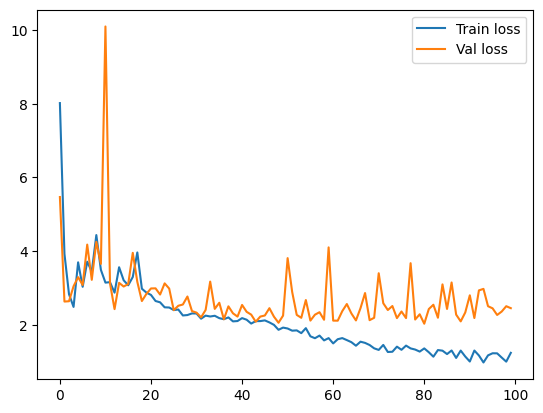

In [69]:
# do the plotting of loss

plt.plot(history.history['loss'],label='Train loss')
plt.plot(history.history['val_loss'],label='Val loss')
plt.legend()
plt.show()

In [70]:
# save the model

saved_model_dir = Path("/kaggle/working/saved_model/")

saved_model_dir.mkdir(exist_ok=True)


In [71]:
from keras.saving import save_model


save_model(model=final_model,
          filepath=saved_model_dir / "emotion_detection_model.keras")